In [1]:
print('Mounting google drive...')

from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/MyDrive"

!mkdir NLP-CW
%cd "/content/drive/MyDrive/NLP-CW"

Mounting google drive...
Mounted at /content/drive
/content/drive/MyDrive
mkdir: cannot create directory ‘NLP-CW’: File exists
/content/drive/MyDrive/NLP-CW


In [2]:
!pip install spacy

In [3]:
!pip install prettytable

In [4]:
!pip install tensorflow

In [6]:
!pip install colorama

In [8]:
## Import required libraries

import os
import re
import spacy
import unicodedata
import matplotlib
import sklearn
import math
import time
import shutil
import pydot
import graphviz

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import tensorflow as tf

from prettytable import PrettyTable
from scipy.spatial import distance
from tqdm import tqdm
from colorama import Fore, Style

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from sklearn.manifold import TSNE

from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Flatten, Embedding, Dropout, Conv1D, Dense, MaxPool1D
from tensorflow.keras import callbacks, Input, utils

from keras import callbacks
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

from gensim.models import Word2Vec


# EDA and Data Preprocessing

In [9]:
# Path to the data files
dataPath = "data/bbc-fulltextDocumentClassification/bbc"

# Generated files
meta_csv = "data/generated/metadata.csv"
parsed_csv = "data/generated/parsed.csv"
preprocessed_csv = "data/generated/preprocessed.csv"

In [10]:
# For Correlation matrix
def corr_matrix(df, target):

    # Pick only numerical columns
    num_df = df.select_dtypes(include=[np.number])

    # Check if there are any filtered numerical columns
    if num_df.empty:
        raise ValueError("Numerical columns not found")

    Cmatrix = num_df.corr()

    # Sort by target (in desc order)
    s_Cmatrix = Cmatrix.sort_values(by=target, ascending=False)

    return s_Cmatrix

In [11]:
# To check if meta.csv exists in the given path or else it creates one

if os.path.exists(meta_csv):
    print("Loading data from existing meta file at:", meta_csv)
    metaData_df = pd.read_csv(meta_csv)
else:
    data_list = [
        [dirName.capitalize(),
         f"{dirName[0].upper()}_{os.path.splitext(fileName)[0]}",
         os.path.getsize(os.path.join(dataPath, dirName, fileName)),
         os.path.join(dataPath, dirName, fileName)]
        for dirName in os.listdir(dataPath) if os.path.isdir(os.path.join(dataPath, dirName))
        for fileName in os.listdir(os.path.join(dataPath, dirName))
    ]

    col_names = ["Doc_Type", "Doc_Id", "File_Size", "Path"]
    metaData_df = pd.DataFrame(data_list, columns=col_names)
    # Handle missing values
    metaData_df.to_csv(meta_csv, index=False, na_rep="")
    print("Meta csv file saved at ", meta_csv)
# Convert Doc_Type to categorical type
metaData_df["Doc_Type"] = metaData_df["Doc_Type"].astype("category")

rows, cols = metaData_df.shape
print(f"\n\nMeta Data file:: \nNumber of rows: {rows} \nNumber of columns {cols}\n")

metaData_df.info()

metaData_df.sample(5)

Loading data from existing meta file at: data/generated/metadata.csv


Meta Data file:: 
Number of rows: 2225 
Number of columns 4

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Doc_Type   2225 non-null   category
 1   Doc_Id     2225 non-null   object  
 2   File_Size  2225 non-null   int64   
 3   Path       2225 non-null   object  
dtypes: category(1), int64(1), object(2)
memory usage: 54.7+ KB


,Doc_Type,Doc_Id,File_Size,Path
1894,Tech,T_065,1946,data/bbc-fulltextDocumentClassification/bbc/te...
1962,Tech,T_171,1843,data/bbc-fulltextDocumentClassification/bbc/te...
1591,Politics,P_173,2496,data/bbc-fulltextDocumentClassification/bbc/po...
341,Entertainment,E_319,1964,data/bbc-fulltextDocumentClassification/bbc/en...
2095,Tech,T_386,4521,data/bbc-fulltextDocumentClassification/bbc/te...


In [12]:
# Check if there are any duplicate Doc_Ids in the data

duplicates = metaData_df.duplicated(subset='Doc_Id', keep='first').sum()

print(f"There are {duplicates} duplicate Doc_Ids in meta data")

There are 0 duplicate Doc_Ids in meta data


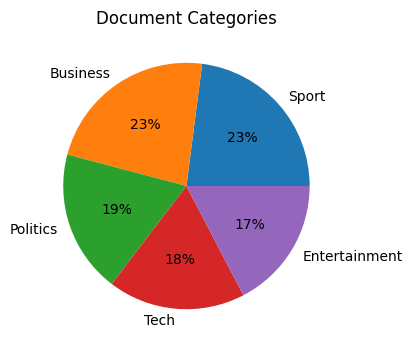

In [13]:
# EDA for Categories - pie chart

category = metaData_df["Doc_Type"].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(x=category, labels=category.index, autopct="%1.0f%%")
plt.title("Document Categories")

plt.show()

Text(0.5, 1.0, 'File size by Categories')

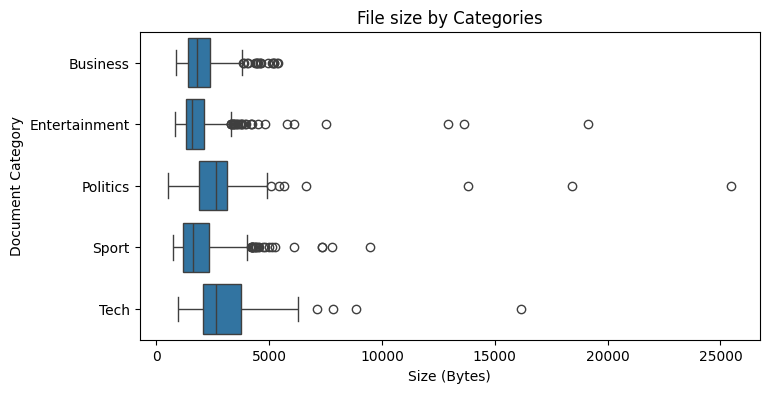

In [14]:
# Identify outliers in the file sizes

plt.figure(figsize=(8,4))
sns.boxplot(data=metaData_df, x="File_Size", y="Doc_Type")
plt.xlabel("Size (Bytes)")
plt.ylabel("Document Category")
plt.title("File size by Categories")

Text(0.5, 1.0, 'File size by Categories - minus outliers')

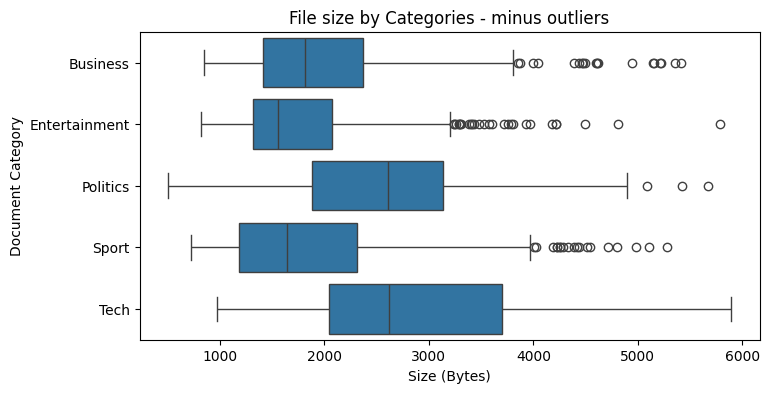

In [15]:
# We can see that most of the file sizes are less than 5900 KB, so ignore outliers and plot again
# for better examination

plt.figure(figsize=(8,4))
sns.boxplot(data=metaData_df[metaData_df["File_Size"] <5900], x="File_Size", y="Doc_Type")
plt.xlabel("Size (Bytes)")
plt.ylabel("Document Category")
plt.title("File size by Categories - minus outliers")

In [16]:
# Remove outliers from the dataframe

metaData_df=metaData_df[metaData_df["File_Size"] <5900]
new_rows, new_cols = metaData_df.shape
print(f"\nAfter removing outliers:: \n\nNumber of rows - {new_rows}\nNumber of columns - {new_cols}")


After removing outliers:: 

Number of rows - 2205
Number of columns - 4


In [17]:
# Clean data

# Function to normalize unicode characters, remove special characters and extra spaces
def clean_data(content):
    norm_content = unicodedata.normalize('NFKD', content)
    clean_content = re.sub(r"([^a-z0-9\s])\1+", " ", norm_content)
    clean_content = re.sub(r"\s+", " ", clean_content).strip()

    return clean_content

# Parse content from the files
def parse_content(docId, filePath):
    with open(filePath, "rb") as txt:
        dec_content = txt.read().decode("utf-8", errors="ignore").strip()

        # if there's whitespace or empty
        if not dec_content or dec_content.isspace():
            return None

        clean_content = clean_data(dec_content)

        return [docId, len(clean_content), clean_content]



In [18]:
# To check if parsed.csv exists in the given path or else it creates one
if os.path.exists(parsed_csv):
    print("Loading data from existing parsed file at:", parsed_csv)
    pars_df = pd.read_csv(parsed_csv)
else:
    parsed_text = [
        parse_content(docId, dataPath)
        for docId, dataPath in tqdm(metaData_df[["Doc_Id", "Path"]].values)
    ]

    # Weed out docs left empty after pre-processing
    parsed_text = [i for i in parsed_text if i is not None]

    # Put parsed content into dataframe
    col_names = ["Doc_Id", "Text_Length", "Text"]
    pars_df = pd.DataFrame(parsed_text, columns=col_names)

    # Save into the csv file
    pars_df.to_csv(parsed_csv, index=False, na_rep="")
    print("Parsed csv file saved at:", parsed_csv)

pars_df.head()

Loading data from existing parsed file at: data/generated/parsed.csv


,Doc_Id,Text_Length,Text
0,E_289,2250,Musicians to tackle US red tape Musicians' gro...
1,E_262,4800,"U2's desire to be number one U2, who have won ..."
2,E_276,2121,Rocker Doherty in on-stage fight Rock singer P...
3,E_060,1041,Snicket tops US box office chart The film adap...
4,E_074,1577,Ocean's Twelve raids box office Ocean's Twelve...


In [19]:
# To load language pipeline - English

!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 34.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [20]:
nlp = spacy.load("en_core_web_sm")

# Check for the nlp pipe names
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [21]:
# Function to perform decontraction on the document using a set of patterns
def decon_doc(doc, pattrn):
    # attribute_ruler allows adding patterns for matching and modifying linguistic annotations
    att_ruler = nlp.get_pipe("attribute_ruler")
    att_ruler.add_patterns(pattrn)

    return doc

# Function to lemmatize, remove whitespace, lowercase and check on stop words and punctuation
def lemm_process(doc, rmv_stopwords=False, rmv_punctuation=False):
    lemm = [
    token.lemma_.strip().lower()
    for token in doc
    if not (rmv_stopwords and token.is_stop)
    and (not rmv_punctuation or not token.is_punct)
]
    return " ".join(lemm)

# Function to get part-of-speech count
def get_pos(doc, docId=None):
    num_pos = {"Doc_Id": docId} if docId else {}
    for element in sorted(doc.count_by(spacy.attrs.POS).items(), key=lambda i: i[0]):
        # Part-of-speech label to text
        pos_lbl = doc.vocab[element[0]].text
        # Assigning number of pos to dictionary
        num_pos[pos_lbl] = element[1]
    return num_pos


# Function to process the language - check on punctuation & stop words, lemmatize and getting p-o-s count
def proc_lang(docId, txt, rmv_stopwords=False, rmv_punctuation=False, decon_pattrn=None):
    content = nlp(str(txt))

    if decon_pattrn:
        content = decon_doc(content, decon_pattrn)

    lemm_content = lemm_process(content, rmv_stopwords, rmv_punctuation)
    num_pos = get_pos(content, docId)

    return lemm_content, num_pos

In [22]:
# Encode category labels
enc_lbls, unq_lbls = pd.factorize(metaData_df["Doc_Type"])

# Map encoded values with original categories
category_map = dict(enumerate(unq_lbls.categories))

# Add "Doc_Categories" clumn to metadata dataframe
metaData_df["Doc_Categories"] = enc_lbls

# Print encoded categories and mapping
print("Encoded categories:\n", category_map)

# Print number of encoded values in "Doc_Categories" column
num_enc_val = metaData_df["Doc_Categories"].value_counts().sort_index()
print("Number of encoded values:\n", num_enc_val)

Encoded categories:
 {0: 'Business', 1: 'Entertainment', 2: 'Politics', 3: 'Sport', 4: 'Tech'}
Number of encoded values:
 Doc_Categories
0    381
1    510
2    506
3    413
4    395
Name: count, dtype: int64


In [23]:
# To check if preprocessed.csv exists in the given path or else it creates one
if os.path.exists(preprocessed_csv):
    print("Loading data from existing preprocessed file at:", preprocessed_csv)
    preproc_df = pd.read_csv(preprocessed_csv)
else:
    # Copy parsed df to language df
    lng_df = pars_df.copy()

    # Process the content
    lemm_txts = []
    nums_pos = []
    for docId, txt in tqdm(lng_df[["Doc_Id", "Text"]].values):
        # Call function to process the language
        lemm, pos = proc_lang(docId, txt)
        lemm_txts.append(lemm)
        nums_pos.append(pos)

    # Update language dataframe's Text' column with lemmatized content
    lng_df["Text"] = lemm_txts

    # create part-of-speech df
    pos_df = pd.DataFrame(nums_pos).fillna(0)

    # Merge language, p-o-s and metadata dataframes and assign to preprocessed dataframe
    preproc_df = lng_df.merge(pos_df, on="Doc_Id").merge(metaData_df, on="Doc_Id")

    # Save the final preprocessed csv
    preproc_df.to_csv(preprocessed_csv, index=False, na_rep="")

preproc_df.head()

Loading data from existing preprocessed file at: data/generated/preprocessed.csv


,Doc_Id,Text_Length,Text,ADJ,ADP,ADV,AUX,CCONJ,DET,NOUN,...,PUNCT,SCONJ,SYM,VERB,X,INTJ,Doc_Type,File_Size,Path,Doc_Categories
0,E_289,2250,musician to tackle us red tape musicians ' gro...,27,35,10.0,27.0,13.0,37,70,...,66,6.0,1.0,62,0.0,0.0,Entertainment,2261,data/bbc-fulltextDocumentClassification/bbc/en...,0
1,E_262,4800,"u2 's desire to be number one u2 , who have wi...",70,89,37.0,43.0,47.0,81,167,...,139,8.0,0.0,111,0.0,0.0,Entertainment,4810,data/bbc-fulltextDocumentClassification/bbc/en...,0
2,E_276,2121,rocker doherty in on - stage fight rock singer...,17,55,10.0,14.0,11.0,32,82,...,46,2.0,1.0,49,0.0,0.0,Entertainment,2127,data/bbc-fulltextDocumentClassification/bbc/en...,0
3,E_060,1041,snicket top us box office chart the film adapt...,9,24,1.0,4.0,1.0,15,40,...,24,3.0,4.0,25,0.0,0.0,Entertainment,1046,data/bbc-fulltextDocumentClassification/bbc/en...,0
4,E_074,1577,ocean 's twelve raid box office ocean 's twelv...,11,25,7.0,6.0,6.0,27,60,...,54,1.0,7.0,27,0.0,0.0,Entertainment,1586,data/bbc-fulltextDocumentClassification/bbc/en...,0


In [24]:
proc_rows, proc_cols = preproc_df.shape
print(f"\nFinal preprocessed data:: \n\nNumber of rows - {proc_rows}\nNumber of columns - {proc_cols}")

preproc_df.info()


Final preprocessed data:: 

Number of rows - 2205
Number of columns - 24
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Doc_Id          2205 non-null   object 
 1   Text_Length     2205 non-null   int64  
 2   Text            2205 non-null   object 
 3   ADJ             2205 non-null   int64  
 4   ADP             2205 non-null   int64  
 5   ADV             2205 non-null   float64
 6   AUX             2205 non-null   float64
 7   CCONJ           2205 non-null   float64
 8   DET             2205 non-null   int64  
 9   NOUN            2205 non-null   int64  
 10  NUM             2205 non-null   float64
 11  PART            2205 non-null   float64
 12  PRON            2205 non-null   float64
 13  PROPN           2205 non-null   int64  
 14  PUNCT           2205 non-null   int64  
 15  SCONJ           2205 non-null   float64
 16  SYM 

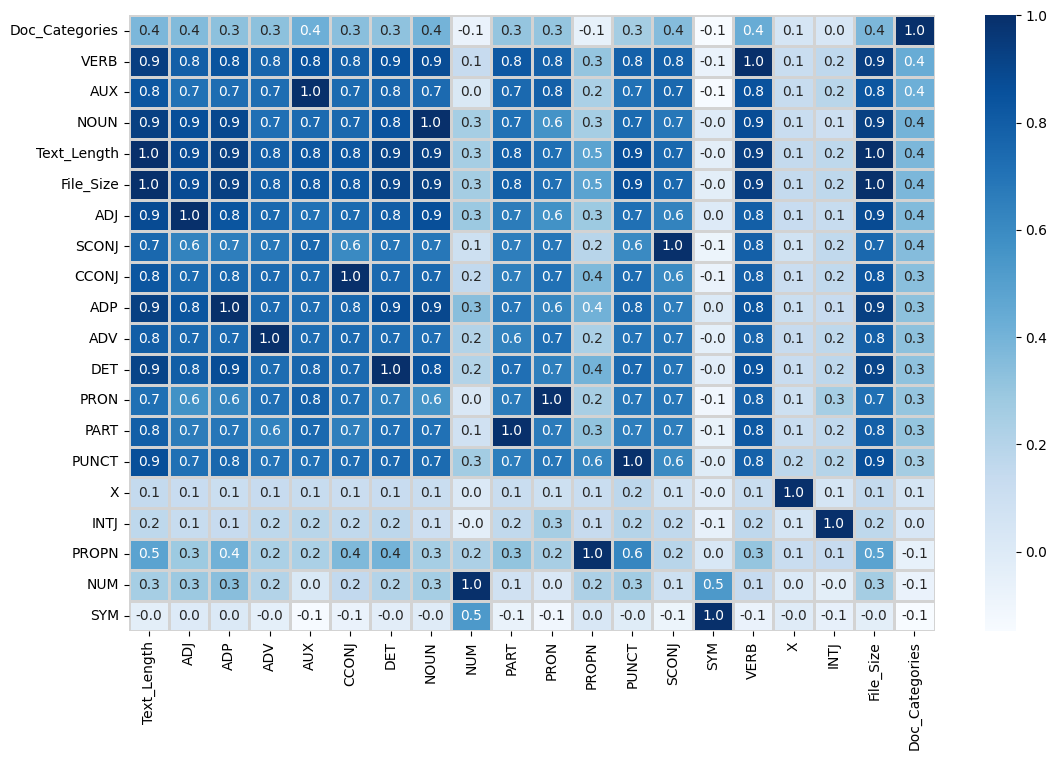

In [25]:
# Get corr matrix and plot a heatmap
co_matrix = corr_matrix(preproc_df, "Doc_Categories")

plt.figure(figsize=(13, 8))
sns.heatmap(co_matrix, cmap="Blues", fmt=".1f", annot=True, linecolor="lightgrey", linewidths=1)

plt.show()

In [26]:
# Pivot pos labels with different doc categories
pos_value = preproc_df.columns.tolist()[3:20]
# Add a new column to final_df with the corresponding class labels
preproc_df['POS_label'] = preproc_df['Doc_Categories'].map(category_map)
preproc_df.pivot_table(index="POS_label", values=pos_value).fillna(0).astype("int64").T

POS_label,Business,Entertainment,Politics,Sport,Tech
ADJ,20,26,21,30,39
ADP,36,41,36,48,58
ADV,9,10,12,13,19
AUX,17,19,21,30,32
CCONJ,9,8,10,12,15
DET,29,31,29,42,44
INTJ,0,0,0,0,0
NOUN,63,81,54,90,120
NUM,9,11,10,6,10
PART,9,11,11,16,15


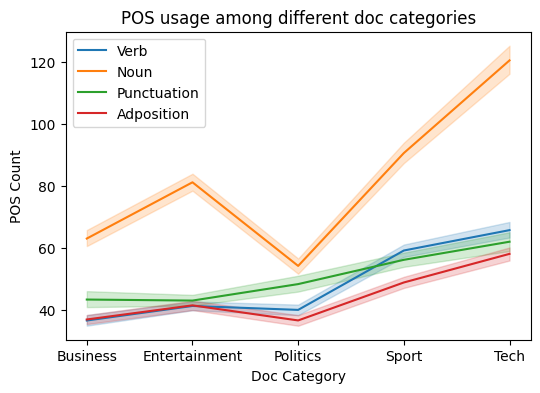

In [27]:
plt.figure(figsize=(6, 4))

sns.lineplot(data=preproc_df, label="Verb", x="POS_label", y="VERB")
sns.lineplot(data=preproc_df, label="Noun", x="POS_label", y="NOUN")
sns.lineplot(data=preproc_df, label="Punctuation", x="POS_label", y="PUNCT")
sns.lineplot(data=preproc_df, label="Adposition", x="POS_label", y="ADP")
plt.ylabel("POS Count")
plt.xlabel("Doc Category")
plt.title("POS usage among different doc categories")

plt.show()

# Modeling -

##

In [28]:
# Custom class to tune decay learning rate through running epochs

# If the accuracy decreases in the current epoch, reduce the learning rate by 10% &
# reduce it by 3% after every 2nd epoch.

class decayLR(callbacks.Callback):
    def __init__(self):
        self.previous_val_accuracy = 0

    def __get_learningRate__(self):
        return float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))

    def __set_learningRate__(self, new_learningRate):
        self.model.optimizer.learning_rate.assign(new_learningRate)
        #tf.keras.backend.set_value(self.model.optimizer.learning_rate, new_learningRate)

    def on_epoch_end(self, epoch, logs=None):
        if self.model.stop_training:
            # Stop further callbacks
            return

        current_val_accuracy = logs.get("val_accuracy")
        learning_rate = self.__get_learningRate__()


        if current_val_accuracy < self.previous_val_accuracy:
            new_learningRate = calc_reduction(learning_rate, 10)
            self.__set_learningRate__(new_learningRate)
            print("Current accuracy - ", round(current_val_accuracy, 4),
                  "\nPrevious accuracy - ", round(self.previous_val_accuracy, 4),
                  "\n\nNew learning rate (after reducing by 10%) - ", round(new_learningRate, 4))
        elif not (epoch + 1) % 2:
            new_learningRate = calc_reduction(learning_rate, 3)
            self.__set_learningRate__(new_learningRate)
            print("\n\nNew learning rate after 2 epochs (after reducing by 3%)", round(new_learningRate, 4))

        # Save current validation accuracy value for next epoch.
        self.previous_val_accuracy = current_val_accuracy


#  Class to terminate training on encountering invalid loss

class terminate_atNaN(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if self.model.stop_training:
            # Stop further callbacks
            return

        # Check if the loss contains NaN or infinite values
        l = logs.get("loss")
        if (l is not None) and (np.isnan(l) or np.isinf(l)):
            print("Invalid loss detected. Terminating at epoch number - ", epoch)
            # Flag for subsequent callbacks
            self.model.stop_training = True
            return
#

# Class to terminate training on no improvement

class terminate_noImprovement(callbacks.EarlyStopping):
    def __init__(self, epochs):
        super().__init__(monitor="val_accuracy", verbose=2, mode="max", patience=epochs)

    def on_epoch_end(self, epoch, logs=None):
        if self.model.stop_training:
            # Stop further callbacks
            return

        super().on_epoch_end(epoch, logs)

#

# Class to calculate and print performance metrics

class perf_metrics(callbacks.Callback):
    def __init__(self, val_data, val_labels):
        self.val_data = val_data
        self.val_labels = val_labels

    def on_epoch_end(self, epoch, logs=None):
        if self.model.stop_training:
            # Stop further callbacks
            return

        pred_prob = self.model.predict(self.val_data)
        pred_labels = np.argmax(pred_prob, axis=1)

        f1Score = f1_score(self.val_labels, pred_labels, average="micro")
        print("F1-score - ", round(f1Score, 4))



# Class to save model with better accuracy checked after each epoch

class save_model(callbacks.ModelCheckpoint):
    def __init__(self, **kwargs):
        super().__init__(
            monitor="val_accuracy",
            mode="max",
            verbose=2,
            save_best_only=True,
            **kwargs
        )

    def on_epoch_end(self, curr_epoch, logs=None):
        # Stop further callbacks
        if self.model.stop_training:
            return

        super().on_epoch_end(curr_epoch, logs)


# Define empty lists to capture loss and accuracy
loss = []
val_loss = []
accuracy = []
val_accuracy = []

# Class to save loss and accuracy over epochs
class lossAccuracy(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss.append(logs['loss'])
        val_loss.append(logs['val_loss'])
        accuracy.append(logs['accuracy'])
        val_accuracy.append(logs['val_accuracy'])


## 1. GloVe (Global Vectors for Word Representation)

In [29]:
glove_file = "data/glove.6B.100d.txt"

log_path = "data/logs"
model_path = "data/models"
GloVe_model = "data/models/GloVe.keras"


num_categories = 5  # Number of categories
op_dimension = 100  # output dimension

# EarlyStopping epoch limit
es_epoch = 3

In [30]:
# Following function shrinks a row by displaying a subset of values at the beginning and end of the row, separated
# by an ellipsis if there are values in between that are not displayed.

def display_n_values(r, n=5):
    if r is None:
        return "[]"

    right_hs = []
    left_hs = []

    for index, value in enumerate(r):
        if index < n:
            left_hs.append(str(value))
        elif index >= (len(r) - n):
            right_hs.append(str(value))

    left_hs = ", ".join(left_hs)
    delimiter = ", ..." if len(r) > 2 * n else ""
    right_hs = f", {', '.join(right_hs)}" if len(right_hs) else ""

    return f"[{left_hs + delimiter + right_hs}]"


# Lambda function - calculates the reduction of the input `value` by a specified `percentage`.
calc_reduction = lambda value, percent: value - (percent * value / 100)


# Following function calculates cosine similarity b/w 2 input words using GloVe
def calc_cosine_similarity(vector_index, w1, w2):

    vector1 = vector_index.get(w1.lower())
    print(f"'{w1}'- {display_n_values(vector1, 3)}")

    vector2 = vector_index.get(w2.lower())
    print(f"'{w2}'- {display_n_values(vector2, 3)}")

    cosine_distance = distance.cosine(vector1, vector2)
    print(f"Cosine similarity bw '{w1}' and '{w2}': {round(cosine_distance, 4)}")

In [31]:
# Integer code the data using Tokenizer API

toknzr = Tokenizer(
    num_words=5000,  # maximum number of words to consider
    filters='!"#*+(),-./:;$%&<=?@>[\\]^`~\t\n{|}',  # characters to filter excluding '_'
    oov_token="<UNK>"  # for Out-of-vocabulary words
)

toknzr.fit_on_texts(preproc_df["Text"].values)

In [32]:
# Retrieve the word index from the tokenizer and calculate the vocabulary size
w_index = toknzr.word_index
vocabSize = len(w_index)  # Word vocabulary size.

print("Vocabulary Size:", vocabSize)
print("\nSample:")
{word: index for word, index in list(w_index.items())[:10]}

Vocabulary Size: 23376

Sample:


{'<UNK>': 1,
 'the': 2,
 'be': 3,
 'to': 4,
 'of': 5,
 'and': 6,
 'a': 7,
 'in': 8,
 'have': 9,
 'say': 10}

In [33]:
encode_docs = toknzr.texts_to_sequences(preproc_df["Text"].values)  # Encode content to sequences

print("\nData type:", type(encode_docs), "\n\n\nSample:\n")
_ = [print(display_n_values(r)) for r in encode_docs[:5]]


Data type: <class 'list'> 


Sample:

[1945, 4, 869, 52, 1161, ..., 4, 1, 12, 16, 96]
[2248, 15, 1946, 4, 3, ..., 23, 25, 172, 98, 38]
[1, 3028, 8, 13, 620, ..., 8, 285, 13, 561, 969]
[1, 155, 52, 618, 297, ..., 30, 444, 13, 36, 2044]
[3030, 15, 4113, 3521, 618, ..., 2423, 2, 1782, 1, 1]


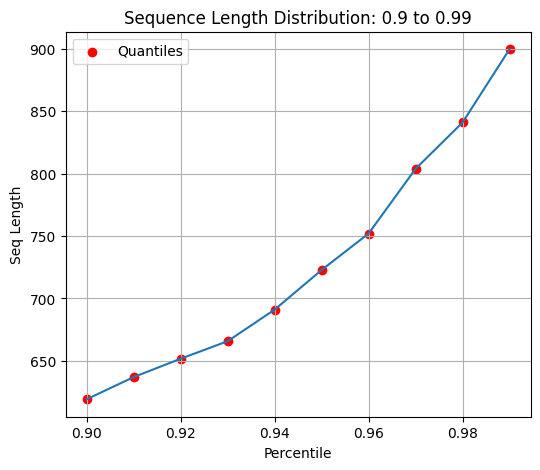

In [34]:
# Use elbow method to choose appropriate sequence length

sequence_len = [len(x) for x in encode_docs] # Get the seuence lengths

l_percent, h_percent = 0.90, 1 # Set lower and higher percentiles
plt.figure(figsize=(6, 5))

percent_range = np.arange(l_percent, h_percent, 0.01)
seq_len_quantiles = np.quantile(a=np.array(sequence_len), q=percent_range)

sns.lineplot(x=percent_range, y=seq_len_quantiles)
plt.scatter(percent_range, seq_len_quantiles, color='red', label='Quantiles')
plt.grid(True)
plt.title(f"Sequence Length Distribution: {l_percent} to {round(h_percent - 0.01, 2)}")
plt.ylabel("Seq Length")
plt.xlabel("Percentile")
plt.legend()

plt.show()

In [35]:
# Now, almost 99 percent of content has 900 sequence length so let's choose 900 as the sequence length
sequence_length = 900


# Padding

p_docs = pad_sequences(encode_docs, maxlen=sequence_length, truncating="post", padding="post")

print("\nShape - ", p_docs.shape, "\n\nData type - ", type(p_docs), "\n\nSample - \n\n", p_docs)


Shape -  (2205, 900) 

Data type -  <class 'numpy.ndarray'> 

Sample - 

 [[1945    4  869 ...    0    0    0]
 [2248   15 1946 ...    0    0    0]
 [   1 3028    8 ...    0    0    0]
 ...
 [1232   96  451 ...    0    0    0]
 [ 515  180  181 ...    0    0    0]
 [2864  951    4 ...    0    0    0]]


In [36]:
%%time

# Load vector for words

gv_idx = dict()
with open(glove_file, encoding="utf8") as gf:
    for txt in gf.readlines():
        cols = txt.split()
        word = cols[0]
        vector = np.array(cols[1:], dtype="float32")
        gv_idx[word] = vector

CPU times: user 16.3 s, sys: 803 ms, total: 17.1 s
Wall time: 34.7 s


In [37]:
print("GloVe index word count - ", len(gv_idx.keys()), "\n\nSample - \n")

t = PrettyTable(["Word", "Vectors"])  #, align="l"
t.add_rows([[wrd, display_n_values(vec, n=3)] for wrd, vec in list(gv_idx.items())[:5]])

print(t)


GloVe index word count -  400000 

Sample - 

+------+-----------------------------------------------------------------+
| Word |                             Vectors                             |
+------+-----------------------------------------------------------------+
| the  |  [-0.038194, -0.24487, 0.72812, ..., -0.1459, 0.8278, 0.27062]  |
|  ,   |  [-0.10767, 0.11053, 0.59812, ..., -0.83155, 0.45293, 0.082577] |
|  .   | [-0.33979, 0.20941, 0.46348, ..., -0.23394, 0.47298, -0.028803] |
|  of  |    [-0.1529, -0.24279, 0.89837, ..., -0.591, 1.0039, 0.20664]   |
|  to  |  [-0.1897, 0.050024, 0.19084, ..., -0.39804, 0.47647, -0.15983] |
+------+-----------------------------------------------------------------+


In [38]:
# Calculate number of words which don't have GloVe vectors

m_words = [w for w in w_index.keys() if w not in gv_idx.keys()]
len_mw = len(m_words)
per_mw = round(len_mw / len(w_index.keys()) * 100,2) # round(len_mw / len(w_index.keys()) * 100, 1)
print(f"{len_mw} or {per_mw}% words don't have vectors")

1312 or 5.61% words don't have vectors


In [39]:
# To load weights

zero_vector = np.zeros(op_dimension)
wt = [zero_vector]

for w in w_index.keys():
    wt.append(gv_idx.get(w, zero_vector).tolist())

wt = tf.convert_to_tensor(wt, dtype=tf.float32)

print(wt.shape)

(23377, 100)


In [40]:
# Split the dataset

X_data = np.column_stack((p_docs, preproc_df.iloc[:, 3:18].astype("int32")))
y_data = preproc_df["Doc_Categories"]

X_train, X_test, y_train, y_test = train_test_split(
    X_data,
    y_data,
    test_size=0.20,
    stratify=y_data,
    random_state=42
)

X_train, X_crossval, y_train, y_crossval = train_test_split(
    X_train,
    y_train,
    test_size=0.3,
    stratify=y_train,
    random_state=42
)

print("X train - ", X_train.shape, "\t;\ty train - ", y_train.shape)

print("\nX val- ", X_crossval.shape, "\t;\ty val - ", y_crossval.shape)

print("\nX test - ", X_test.shape, "\t;\ty test - ", y_test.shape)

X train -  (1234, 915) 	;	y train -  (1234,)

X val-  (530, 915) 	;	y val -  (530,)

X test -  (441, 915) 	;	y test -  (441,)


In [41]:
# Scaling

sc = StandardScaler()
sc.fit(X_train)

# train set - scaled
s_X_train = sc.transform(X_train)

# cross validation set - scaled
s_X_crossval = sc.transform(X_crossval)

# test set - scaled
s_X_test = sc.transform(X_test)

In [42]:
# Re-shape

r_X_train = np.expand_dims(X_train, axis=2)
r_X_crossval = np.expand_dims(X_crossval, axis=2)
r_X_test = np.expand_dims(X_test, axis=2)

print("Re-shaped X train - ", r_X_train.shape)
print("Re-shaped X validation - ", r_X_crossval.shape)
print("Re-shaped X test - ", r_X_test.shape)

## Note: Scaled datasets were limiting the resultant accuracy to 36%, so we dropped the scaled sets.

Re-shaped X train -  (1234, 915, 1)
Re-shaped X validation -  (530, 915, 1)
Re-shaped X test -  (441, 915, 1)


In [43]:
# Clear keras session
tf.keras.backend.clear_session()

In [53]:
# Defining the model architecture

num_rows, num_cols = X_train.shape

# Layer - Input
input_layer = Input(shape=(num_cols,), name="Input_Layer")

# Layer - Embedding
emb_input = Embedding(
    vocabSize + 1,
    op_dimension,
    input_length=num_cols,
    name="Embedding_Layer",
    weights=[wt],
    trainable=False,
)(input_layer)


# Layer - Convolutional 1 & Max pooling
conv_a = Conv1D(4, 3, padding="same", activation="relu", name="Conv1D_A_Filters")(emb_input)
conv_b = Conv1D(8, 3, padding="same", activation="relu", name="Conv1D_B_Filters")(emb_input)
conv_c = Conv1D(16, 3, padding="same", activation="relu", name="Conv1D_C_Filters")(emb_input)
concat_abc = tf.keras.layers.concatenate([conv_a, conv_b, conv_c], name="Concat1_ABC")
maxpool1 = MaxPool1D(3, name="MaxPoolLayer1")(concat_abc)

# Layer - Convolutional 2 & Max pooling
conv_d = Conv1D(2, 3, padding="same", activation="relu", name="Conv1D_D_Filters")(maxpool1)
conv_e = Conv1D(4, 3, padding="same", activation="relu", name="Conv1D_E_Filters")(maxpool1)
conv_f = Conv1D(8, 3, padding="same", activation="relu", name="Conv1D_F_Filters")(maxpool1)
concat_def = tf.keras.layers.concatenate([conv_d, conv_e, conv_f], name="Concat2_DEF")
maxpool2 = MaxPool1D(3, name="MaxPoolLayer2")(concat_def)


conv_p = Conv1D(8, 3, padding="same", activation="relu", name="Conv1D_P_Filters")(maxpool2)
flattened = Flatten(name="Flatten")(conv_p)
dropout = Dropout(0.25, name="DropOut")(flattened)
dense1 = Dense(30, activation="relu", name="Dense1")(dropout)

output_layer = Dense(num_categories, activation="softmax", name="Output_layer")(dense1)

doc_classifier_model1 = tf.keras.Model(inputs=input_layer, outputs=output_layer,
                                       name="GloVe_Global_Vectors_for_Word_Representation")
doc_classifier_model1.summary()

Model: "GloVe_Global_Vectors_for_Word_Representation"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_Layer (InputLayer)    [(None, 915)]                0         []                            
                                                                                                  
 Embedding_Layer (Embedding  (None, 915, 100)             2337700   ['Input_Layer[0][0]']         
 )                                                                                                
                                                                                                  
 Conv1D_A_Filters (Conv1D)   (None, 915, 4)               1204      ['Embedding_Layer[0][0]']     
                                                                                                  
 Conv1D_B_Filters (Conv1D)   (None, 915, 8)            

In [54]:
# Compile model - using sparse_categorical_crossentropy since the target is integer list

doc_classifier_model1.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(0.002),
    metrics=["accuracy"],
)

In [55]:
# Train the model

_ = doc_classifier_model1.fit(
    x=r_X_train,
    y=y_train,
    batch_size=89,
    epochs=15,
    verbose=2,
    callbacks=[
        callbacks.TensorBoard(log_path, histogram_freq=1),
        terminate_atNaN(),
        perf_metrics(r_X_crossval, y_crossval),
        decayLR(),
        save_model(filepath=GloVe_model),
        terminate_noImprovement(epochs=es_epoch),
        lossAccuracy()
    ],
    validation_data=(r_X_crossval, y_crossval),
    #class_weight=class_wts
)

Epoch 1/15
17/17 [==============================] - 1s 51ms/step
F1-score -  0.4283

Epoch 1: val_accuracy improved from -inf to 0.42830, saving model to data/models/GloVe.keras
14/14 - 13s - loss: 1.5402 - accuracy: 0.3112 - val_loss: 1.4030 - val_accuracy: 0.4283 - 13s/epoch - 903ms/step
Epoch 2/15
17/17 [==============================] - 1s 56ms/step
F1-score -  0.6396


New learning rate after 2 epochs (after reducing by 3%) 0.0019

Epoch 2: val_accuracy improved from 0.42830 to 0.63962, saving model to data/models/GloVe.keras
14/14 - 12s - loss: 1.1717 - accuracy: 0.5421 - val_loss: 0.9513 - val_accuracy: 0.6396 - 12s/epoch - 867ms/step
Epoch 3/15
17/17 [==============================] - 1s 32ms/step
F1-score -  0.8358

Epoch 3: val_accuracy improved from 0.63962 to 0.83585, saving model to data/models/GloVe.keras
14/14 - 8s - loss: 0.6813 - accuracy: 0.7682 - val_loss: 0.5161 - val_accuracy: 0.8358 - 8s/epoch - 546ms/step
Epoch 4/15
17/17 [==============================] - 1s 56m

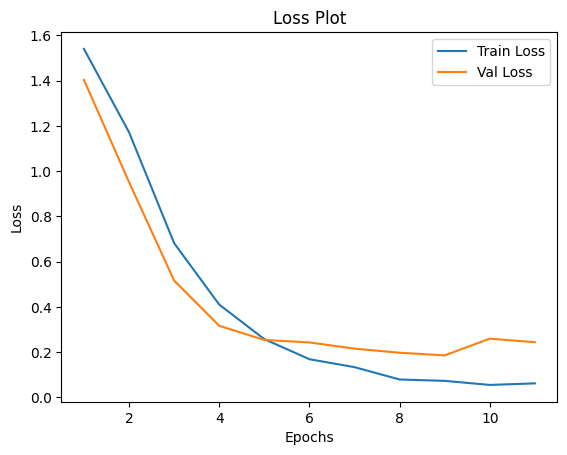

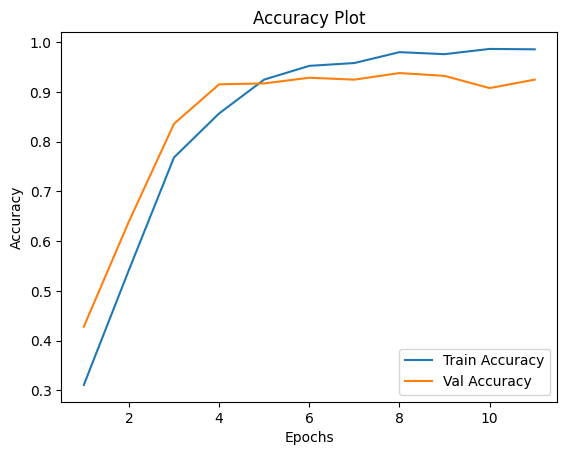

In [56]:
epochs = range(1, len(loss) + 1)

# Plot the loss curve
plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curve
plt.plot(epochs, accuracy, label='Train Accuracy')
plt.plot(epochs, val_accuracy, label='Val Accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [57]:
# Evaluate the saved model

doc_classifier_model1.evaluate(r_X_test, y_test)

14/14 [==============================] - 0s 32ms/step - loss: 0.2864 - accuracy: 0.9206


[0.2864074110984802, 0.920634925365448]

14/14 [==============================] - 0s 32ms/step


Classification Report - 


               precision    recall  f1-score   support

Entertainment       0.91      0.97      0.94        76
     Business       0.94      0.86      0.90       102
        Sport       0.96      1.00      0.98       101
     Politics       0.85      0.95      0.90        83
         Tech       0.94      0.81      0.87        79

     accuracy                           0.92       441
    macro avg       0.92      0.92      0.92       441
 weighted avg       0.92      0.92      0.92       441



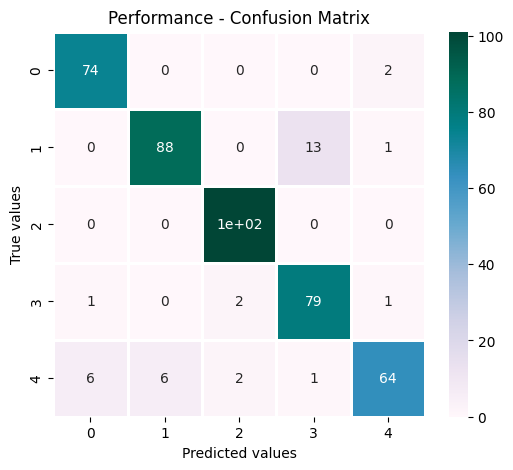

In [58]:
# Plot performance metrics

# Predict probability and labels
pred_prob = doc_classifier_model1.predict(r_X_test)
pred_labels = np.argmax(pred_prob, axis=1)

class_report = classification_report(y_test, pred_labels,target_names=unq_lbls)

# Print the classification report
print("\n\nClassification Report - \n\n")
print(class_report)

# Calculate confusion matrix
conf_mat = tf.math.confusion_matrix(y_test, pred_labels, num_categories).numpy()

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat,
    annot=True,
    cmap="PuBuGn",
    linewidths=1,
    yticklabels=category_map.keys(),
)
plt.title("Performance - Confusion Matrix")
plt.xlabel("Predicted values")
plt.ylabel("True values")

plt.show()

##



##

## 2. Word2Vec - LSTM (Long Short Term Memory)

In [59]:
# Set path for final Word2Vec model
Word2Vec_model = "data/models/Word2Vec.keras"

# Train Word2Vec model
sentences = [text.split() for text in preproc_df["Text"]]

model = Word2Vec(sentences, vector_size=100, window=5, min_count=1)
model.build_vocab(sentences, progress_per=10000)
model.train(sentences, total_examples=model.corpus_count, epochs=5, report_delay=1)

model.save(Word2Vec_model)


In [60]:
# Clear keras session
tf.keras.backend.clear_session()

In [61]:
# Define max sequence length & embedding dimension
max_len = 100
embedding_dim = 100

# Load the pre-trained word2vec model
w2v_model = Word2Vec.load("data/models/Word2Vec.keras")

# Function to prepare the sequences
def prepare_seq(texts, tokenizer, vocab):
    sequences = tokenizer.texts_to_sequences(texts)
    # Sequences with words missing in vocab
    sequences = [[word for word in seq if word in vocab] for seq in sequences]
    # Pad sequences to max length
    sequences = pad_sequences(sequences, maxlen=max_len, padding="post")
    return sequences

X = preproc_df['Text'].values

# Convert category labels to numerical values
lbl_encoder = LabelEncoder()
y = lbl_encoder.fit_transform(preproc_df["Doc_Categories"])


In [62]:
# Split the dataset

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.3,
    stratify=y_train,
    random_state=42
)

print("X train - ", X_train.shape, "\t;\ty train - ", y_train.shape)

print("\nX val- ", X_val.shape, "\t;\ty val - ", y_val.shape)

print("\nX test - ", X_test.shape, "\t;\ty test - ", y_test.shape)


X train -  (1234,) 	;	y train -  (1234,)

X val-  (530,) 	;	y val -  (530,)

X test -  (441,) 	;	y test -  (441,)


In [63]:
# Tokenize
toknzr = Tokenizer(
    num_words=5000,  # maximum number of words to consider
    filters='!"#*+(),-./:;$%&<=?@>[\\]^`~\t\n{|}',  # characters to filter excluding '_'
    oov_token="<UNK>"  # for Out-of-vocabulary words
)

toknzr.fit_on_texts(preproc_df["Text"].values)
# Retrieve the word index from the tokenizer and calculate the vocabulary size
w_index = toknzr.word_index

# Get vocab from model
vocab = set(w2v_model.wv.key_to_index)

sequences = prepare_seq(X_train, toknzr, vocab)
val_sequences = prepare_seq(X_val, toknzr, vocab)
test_sequences = prepare_seq(X_test, toknzr, vocab)

# Word embedding matrix

embedding_matrix = np.zeros((len(w_index) + 1, embedding_dim))
for word, i in w_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

# Define model
doc_classifier_model2 = keras.Sequential(name='Word2Vec_LSTM_Sequential_Model')

# Embedding layer

doc_classifier_model2.add(keras.layers.Embedding(len(w_index) + 1, embedding_dim, weights=[embedding_matrix],
                                                 input_length=max_len, trainable=False))

# LSTM layer
doc_classifier_model2.add(keras.layers.LSTM(64))

# Dense layers - output
doc_classifier_model2.add(keras.layers.Dense(32, activation="relu"))
doc_classifier_model2.add(keras.layers.Dense(1, activation="sigmoid"))

# Compile model
doc_classifier_model2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model

history = doc_classifier_model2.fit(sequences, y_train, epochs=20, batch_size=32,
                                    callbacks=[
                                            callbacks.TensorBoard(log_path, histogram_freq=1),
                                            terminate_atNaN(),
                                            perf_metrics(val_sequences, y_val),
                                            decayLR(),
                                            save_model(filepath=Word2Vec_model),
                                            #terminate_noImprovement(epochs=es_epoch),
                                            ],
                                    validation_data=(val_sequences, y_val))

Epoch 1/20
17/17 [==============================] - 1s 18ms/step
F1-score -  0.1736

Epoch 1: val_accuracy improved from -inf to 0.23019, saving model to data/models/Word2Vec.keras
39/39 [==============================] - 9s 176ms/step - loss: 0.6664 - accuracy: 0.2310 - val_loss: 0.6371 - val_accuracy: 0.2302
Epoch 2/20
17/17 [==============================] - 0s 19ms/step
F1-score -  0.1736


New learning rate after 2 epochs (after reducing by 3%) 0.001

Epoch 2: val_accuracy did not improve from 0.23019
39/39 [==============================] - 3s 87ms/step - loss: 0.6108 - accuracy: 0.2318 - val_loss: 0.5821 - val_accuracy: 0.2302
Epoch 3/20
17/17 [==============================] - 0s 19ms/step
F1-score -  0.1736

Epoch 3: val_accuracy did not improve from 0.23019
39/39 [==============================] - 4s 95ms/step - loss: 0.5563 - accuracy: 0.2318 - val_loss: 0.5286 - val_accuracy: 0.2302
Epoch 4/20
17/17 [==============================] - 1s 30ms/step
F1-score -  0.1736


New le

In [64]:
# Print the summary
doc_classifier_model2.summary()

Model: "Word2Vec_LSTM_Sequential_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          2337700   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2382053 (9.09 MB)
Trainable params: 44353 (173.25 KB)
Non-trainable params: 2337700 (8.92 MB)
_________________________________________________________________


In [65]:
# Evaluate model
val_loss, val_accuracy = doc_classifier_model2.evaluate(val_sequences, y_val)

# Printing the test loss and accuracy
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

test_loss, test_accuracy = doc_classifier_model2.evaluate(test_sequences, y_test)

# Printing the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

17/17 [==============================] - 0s 21ms/step - loss: -0.2185 - accuracy: 0.2302
Validation Loss: -0.21845799684524536
Validation Accuracy: 0.23018868267536163
14/14 [==============================] - 0s 19ms/step - loss: -0.2202 - accuracy: 0.2313
Test Loss: -0.22016459703445435
Test Accuracy: 0.2312925159931183


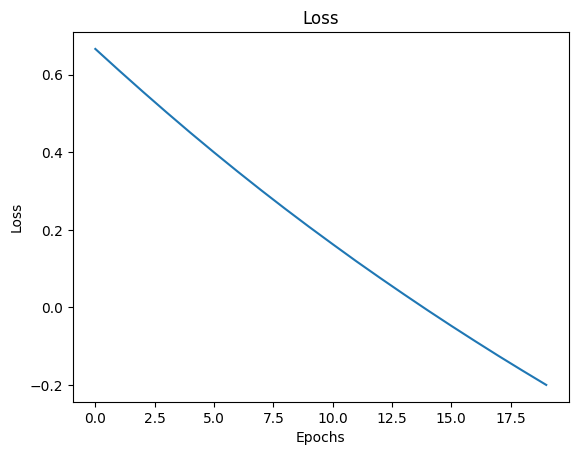

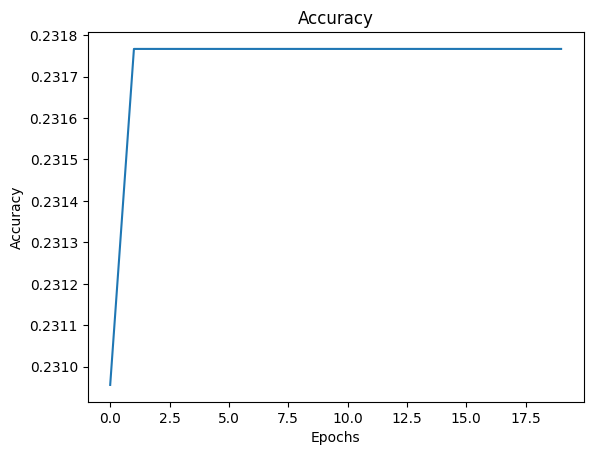

14/14 [==============================] - 0s 19ms/step


Classification Report - 


               precision    recall  f1-score   support

Entertainment       0.17      1.00      0.29        76
     Business       0.00      0.00      0.00       102
        Sport       0.00      0.00      0.00       101
     Politics       0.00      0.00      0.00        83
         Tech       0.00      0.00      0.00        79

     accuracy                           0.17       441
    macro avg       0.03      0.20      0.06       441
 weighted avg       0.03      0.17      0.05       441



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [66]:
# Plot loss
plt.plot(history.history['loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Plot accuracy
plt.plot(history.history['accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Predict through test dataset
y_pred = doc_classifier_model2.predict(test_sequences)
pred_labels = np.argmax(y_pred, axis=1)

class_report = classification_report(y_test, pred_labels,target_names=unq_lbls)

# Print the classification report
print("\n\nClassification Report - \n\n")
print(class_report)

### References:
###### 1. https://moodle4.city.ac.uk/course/view.php?id=6018
###### 2. https://stackoverflow.com
###### 3. https://medium.com